本章节内容改编自:

📌 [Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting](https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

# <b>1 <span style='color:#F1C40F'>|</span> 利用Seq2Seq做时间序列预测</b>




<b></b>
<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>创建时间序列预测数据</b></p>
</div>




### 首先，我们模拟一个二元时间时间序列数据：



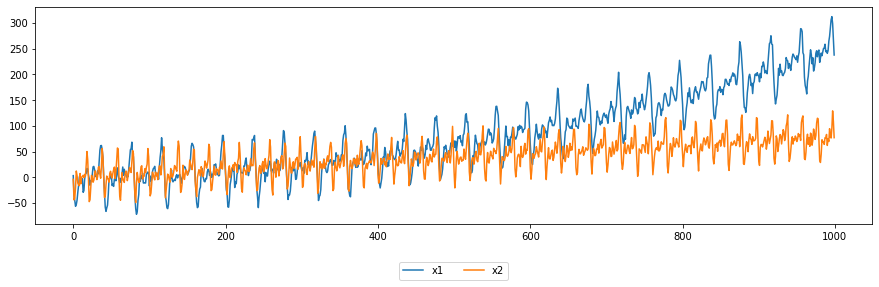

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()



### 切分为训练与测试集：



In [3]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


In [4]:
x_index = np.array(range(len(t)))

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>数据预处理</b></p>
</div>


### Detrend / 去趋势化

It is not a must to detrend time series. However stationary time series will make model training much easier. There are many ways to detrend time series, such as taking difference of sequence with its lag1. Here for the simplicity, we assume the order of trend is known and we are just going to simply fit separate trend lines to x1 and x2, and then subtract the trend from the corresponding original sequence.

We will create index number of each position in the sequence, for easier detrending and trend recover.

Here we will use np.polyfit to complete this small task. Note that only the first 800 data points are used to fit the trend lines, this is because we want to avoid data leak.



In [5]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.44950952e-04  6.38383123e-03 -2.40671226e+00]
[ 0.07996054 -0.76932609]


Based on the above values we got, we can now come up with the trend lines for x1 and x2.

In [6]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

Let’s plot the trend lines together with x1 and x2, and check if they look good.

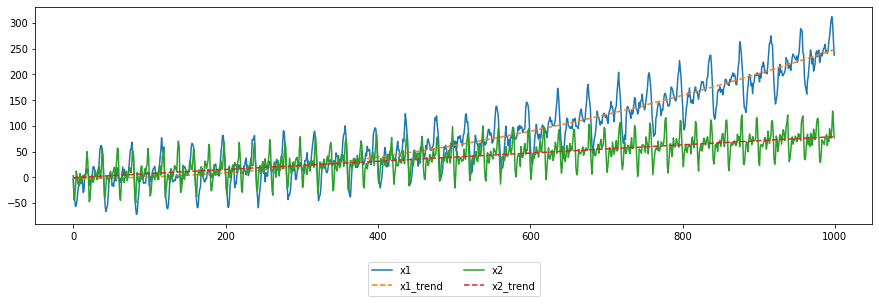

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

The above result looks fine, now we can deduct the trend.

After removing the trend, x1 and x2 become stationary.

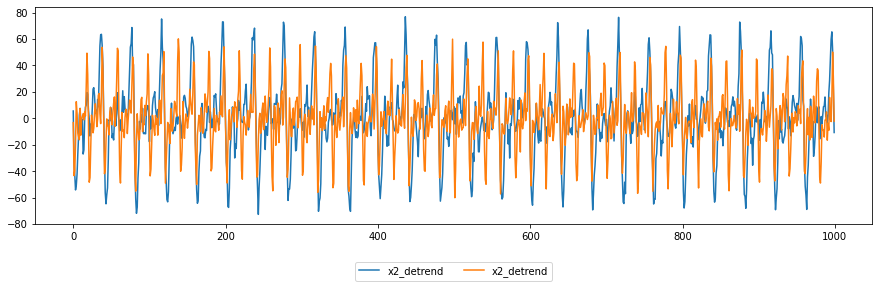

In [8]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### 整合多元时间序列

For easier preprocessing in next several steps, we can combine the sequences and their relevant information together into one array.

In the combined array we created x_lbl:

- the first column is the detrended x1

- the second column is the detrended x2

- the third column is the index

- the fourth column is the label (1 for train set and 0 for test set)

In [9]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  5.49912432  -3.30998891   0.           1.        ]
 [-31.34105835 -43.38728157   1.           1.        ]
 [-43.16496933 -39.82377709   2.           1.        ]
 ...
 [ 51.20042145  50.08160946 997.           0.        ]
 [ 21.6324215   29.42282685 998.           0.        ]
 [-10.77567606  -2.18318189 999.           0.        ]]


### 数值规范化

Normalisation can help model avoid favouring large features while ignoring very small features. Here we can just simply normalise x1 and x2 by dividing the corresponding maximum values in train set.


In [10]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[76.81850006182103, 60.07301839672044, 1, 1]


Note that the above code only calculates maximum value of column 1 (detrended x1) and column 2 (detrended x2), the denominator of column 3 (index) and column 4 (label) are set to 1. This is because we do not input column 3 and column 4 into neural network, and hence no need to normalise them.

fter normalisation, all the values are more or less within range from -1 to 1.

In [11]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 7.15859372e-02 -5.50994274e-02  0.00000000e+00  1.00000000e+00]
 [-4.07988418e-01 -7.22242410e-01  1.00000000e+00  1.00000000e+00]
 [-5.61908515e-01 -6.62922859e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.66511601e-01  8.33678926e-01  9.97000000e+02  0.00000000e+00]
 [ 2.81604320e-01  4.89784393e-01  9.98000000e+02  0.00000000e+00]
 [-1.40274492e-01 -3.63421374e-02  9.99000000e+02  0.00000000e+00]]


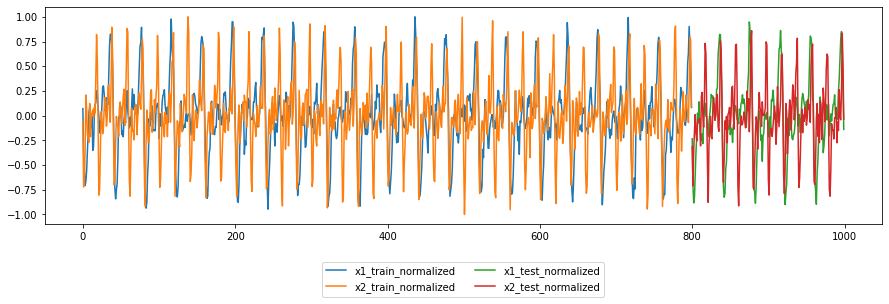

In [12]:

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### 样本化

Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays.

![](https://miro.medium.com/max/1400/1*uYT9F6XDKTQKm8qgxC03Pw.png)
    
The function truncate generates 3 arrays:

- input to neural network X_in: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: detrended and normalised x1, detrended and normalised x2, and original assigned data position index. Only the first 2 features will be used for training.

- target in neural network X_out: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in X_in. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.

- label lbl: 1 for train set and 0 for test set.

In [13]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [14]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


Now the data is ready to be input into neural network!

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>定义基于GRU层的Seq2Seq网络</b></p>
</div>



![](https://blog.floydhub.com/content/images/2019/09/Slide37-1.JPG)


### Simple Seq2Seq GRU Model

![](https://camo.githubusercontent.com/fe3df3ef6c0fb05767a373ef8e547120a0a667c423a5c52f3f202156b8aba1e5/68747470733a2f2f696e6372656469626c652e61692f6173736574732f696d616765732f736571327365712d736571327365715f74732e706e67)
    


In [15]:
# Set number of hidden layers:
n_hidden = 100

#### The input layer

In [16]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


#### The encoder GRU

We need to pay attention to 2 import parameters return_sequences and return_state, because they decide what GRU returns.

- return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.

- return_state: Boolean. Whether to return the last state in addition to the output. Default: False.

In [17]:
encoder_output, encoder_last_state = GRU(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_output)
print(encoder_last_state)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru/strided_slice_3:0', description="created by layer 'gru'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru/while:4', description="created by layer 'gru'")


Batch normalisation is added because we want to avoid gradient explosion caused by the activation function ELU in the encoder.

In [18]:
encoder_last_state = BatchNormalization(momentum=0.6)(encoder_last_state)

Next, we make 20 copies of the last hidden state of encoder and use them as input to the decoder. 

In [19]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_state)
decoder = GRU(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_state])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='gru_1/transpose_1:0', description="created by layer 'gru_1'")


In [20]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


Then we put everything into the model, and compile it. Here we simply use MSE as the loss function and MAE as the evaluation metric. Note that we set clipnorm=1 for Adam optimiser. This is to normalise the gradient, so as to avoid gradient explosion during back propagation.

In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 gru (GRU)                      [(None, 100),        31200       ['input_1[0][0]']                
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['gru[0][1]']                    
 alization)                                                                                       
                                                                                              

C:\Users\echotu\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We can also plot the model:

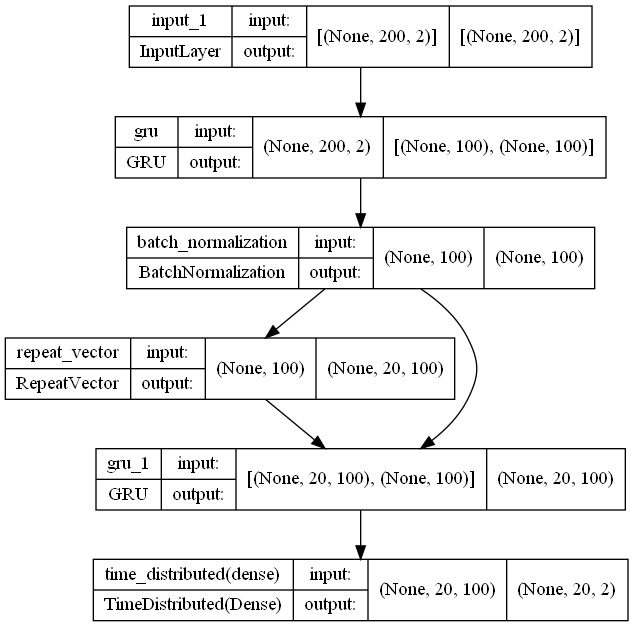

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>网络学习</b></p>
</div>


In [23]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq_gru.h5')

Epoch 1/100
5/5 [==============================] - 5s 381ms/step - loss: 4.7157 - mae: 1.3210 - val_loss: 0.1756 - val_mae: 0.3213
Epoch 2/100
5/5 [==============================] - 1s 279ms/step - loss: 0.4598 - mae: 0.5088 - val_loss: 0.1945 - val_mae: 0.3503
Epoch 3/100
5/5 [==============================] - 1s 275ms/step - loss: 0.2128 - mae: 0.3587 - val_loss: 0.1567 - val_mae: 0.2973
Epoch 4/100
5/5 [==============================] - 1s 266ms/step - loss: 0.1652 - mae: 0.3082 - val_loss: 0.1485 - val_mae: 0.2912
Epoch 5/100
5/5 [==============================] - 1s 278ms/step - loss: 0.1523 - mae: 0.2948 - val_loss: 0.1352 - val_mae: 0.2679
Epoch 6/100
5/5 [==============================] - 1s 276ms/step - loss: 0.1437 - mae: 0.2806 - val_loss: 0.1303 - val_mae: 0.2620
Epoch 7/100
5/5 [==============================] - 1s 267ms/step - loss: 0.1346 - mae: 0.2702 - val_loss: 0.1285 - val_mae: 0.2610
Epoch 8/100
5/5 [==============================] - 1s 278ms/step - loss: 0.1305 - m

5/5 [==============================] - 2s 376ms/step - loss: 0.0468 - mae: 0.1555 - val_loss: 0.0268 - val_mae: 0.1254
Epoch 64/100
5/5 [==============================] - 2s 380ms/step - loss: 0.0414 - mae: 0.1507 - val_loss: 0.0401 - val_mae: 0.1533
Epoch 65/100
5/5 [==============================] - 2s 373ms/step - loss: 0.0478 - mae: 0.1573 - val_loss: 0.0292 - val_mae: 0.1308
Epoch 66/100
5/5 [==============================] - 2s 384ms/step - loss: 0.0514 - mae: 0.1642 - val_loss: 0.0278 - val_mae: 0.1259
Epoch 67/100
5/5 [==============================] - 2s 369ms/step - loss: 0.0512 - mae: 0.1632 - val_loss: 0.0352 - val_mae: 0.1431
Epoch 68/100
5/5 [==============================] - 2s 371ms/step - loss: 0.0486 - mae: 0.1596 - val_loss: 0.0337 - val_mae: 0.1379
Epoch 69/100
5/5 [==============================] - 2s 366ms/step - loss: 0.0488 - mae: 0.1600 - val_loss: 0.0447 - val_mae: 0.1576
Epoch 70/100
5/5 [==============================] - 2s 379ms/step - loss: 0.0454 - mae: 0

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>使用网络得到预测结果</b></p>
</div>


### Prediction

The model prediction as well as the true values are unnormalised:



In [24]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.

In [25]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


Next, we put all the outputs with recovered trend into a dictionary data_final.



In [26]:

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


We can plot MAE of all samples in time order, to see if there is clear pattern. The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.

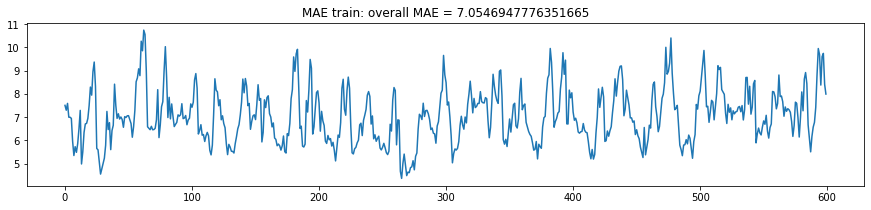

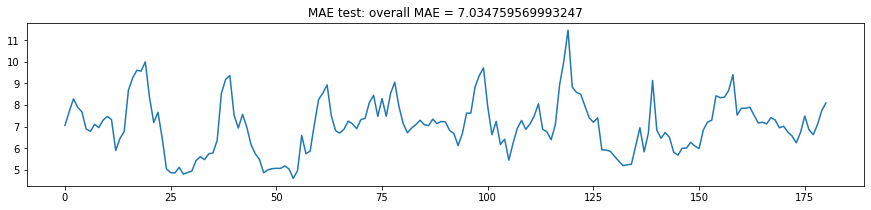

In [28]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned.

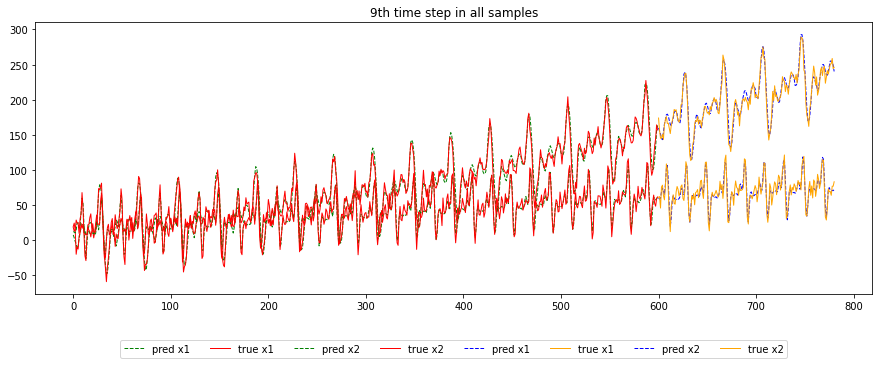

In [29]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

Take a closer look at the prediction on test set:

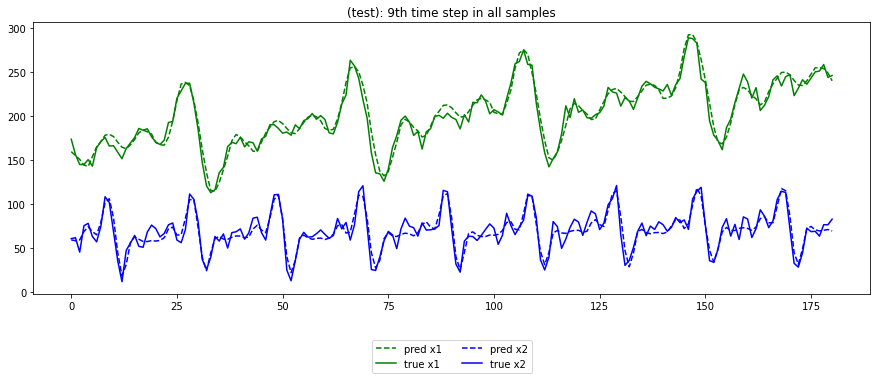

In [30]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# <b>1 <span style='color:#F1C40F'>|</span> 加入attention机制的Seq2Seq网络</b>

<b></b>
<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>定义带 Luong Attention的Seq2Seq网络</b></p>
</div>



### Bahdanau Attention

![](https://blog.floydhub.com/content/images/2019/09/Slide38.JPG)

- Producing the Encoder Hidden States

- Calculating Alignment Scores by *scores = s(previous decoder hidden state, each encoder's hidden state)*

- Softmaxing the Alignment Scores 

- Calculating the Context Vector

- Decoding the Output by *Decoder RNN for each time step = concatenate(context vector, previous decoder output, previous decoder hidden state)*

### Luong Attention


![](https://blog.floydhub.com/content/images/2019/09/Slide51.JPG)

- Producing the Encoder Hidden States

- **Producing the Decoder Hidden States**

- Calculating Alignment Scores by ***scores = s(decoder hidden state, each encoder's hidden state)***

- Softmaxing the Alignment Scores 

- Calculating the Context Vector

- The context vector is concatenated with the decoder hidden state as passed through a fully connected layer to produce a new output

![](https://pic1.zhimg.com/v2-03e243612c755bce746bc8a84e675a94_1440w.jpg?source=172ae18b)

### The Input layer

It is the same as in Model 1:

In [31]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

### The encoder GRU

This is slightly different from Model 1: besides returning the last hidden state, we also need to return the stacked hidden states for alignment score calculation.

In [48]:
#在这里，我们设置return_sequences为True，这样encoder_stack_h就对应了shape=(None, 20, 100)的所有隐层状态
encoder_stack_h, encoder_last_state = GRU(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_state)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='gru_4/transpose_1:0', description="created by layer 'gru_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='gru_4/while:4', description="created by layer 'gru_4'")


Next, we apply batch normalisation to avoid gradient explosion.

In [33]:
encoder_last_state = BatchNormalization(momentum=0.6)(encoder_last_state)

### The Decoder GRU

Next, we repeat the last hidden state of encoder 20 times, and use them as input to decoder GRU.

In [34]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_state)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


We also need to get the stacked hidden state of de decoder for alignment score calculation.


In [35]:
decoder_stack_h = GRU(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_state])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='gru_3/transpose_1:0', description="created by layer 'gru_3'")


### Attention Layer

To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [37]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


Then we can calculate the context vector, and also apply batch normalisation on top of it:

In [38]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


Now we concat the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.

In [39]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [40]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


Then we can compile the model. The parameters are the same as those in Model 1, for the sake of comparing the performance of the 2 models.

In [41]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 gru_2 (GRU)                    [(None, 200, 100),   31200       ['input_3[0][0]']                
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 100)         400         ['gru_2[0][1]']                  
 rmalization)                                                                                     
                                                                                            

C:\Users\echotu\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


How data flow through the model:

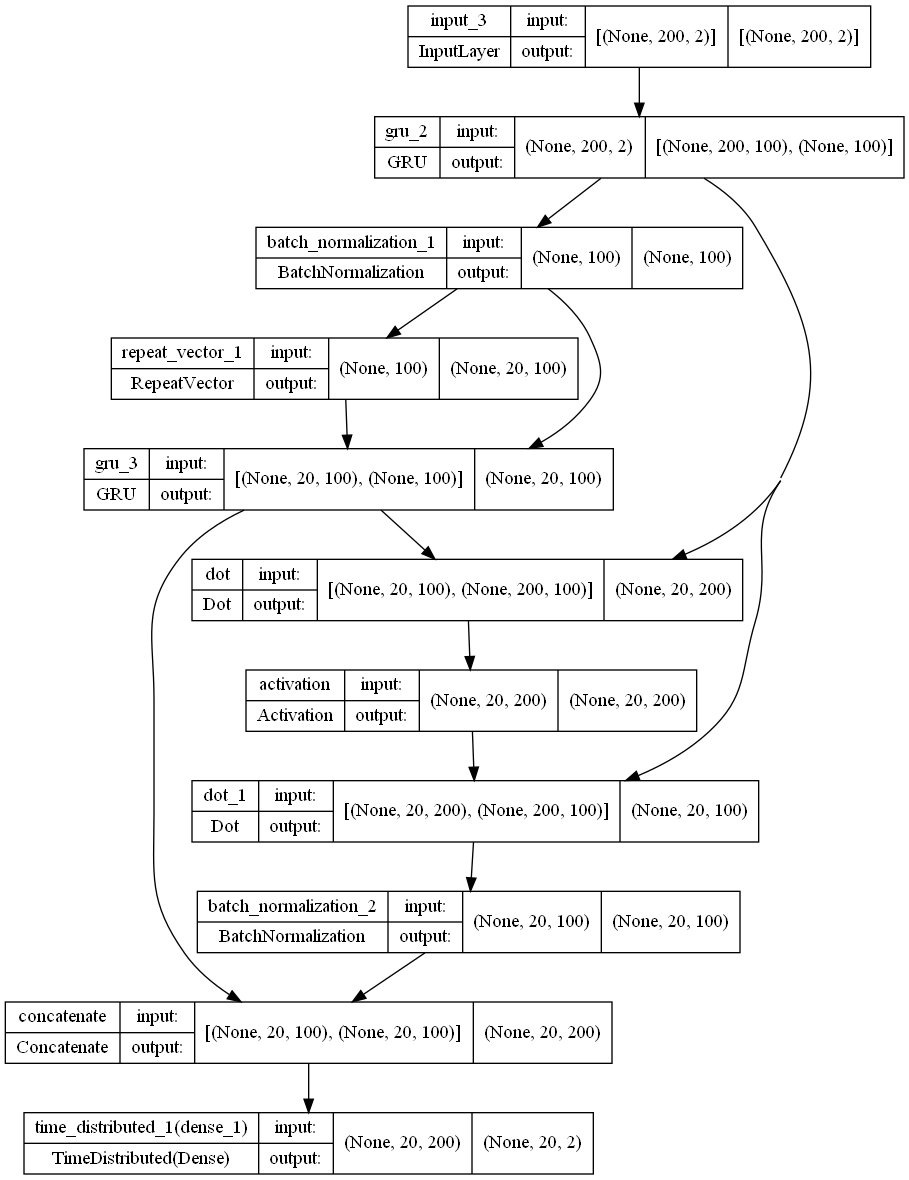

In [42]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq_attention.h5')

Epoch 1/100
5/5 [==============================] - 6s 503ms/step - loss: 2.3210 - mae: 0.9103 - val_loss: 0.1474 - val_mae: 0.2828
Epoch 2/100
5/5 [==============================] - 2s 405ms/step - loss: 0.2185 - mae: 0.3572 - val_loss: 0.2163 - val_mae: 0.3651
Epoch 3/100
5/5 [==============================] - 2s 406ms/step - loss: 0.1600 - mae: 0.3012 - val_loss: 0.1340 - val_mae: 0.2702
Epoch 4/100
5/5 [==============================] - 2s 416ms/step - loss: 0.1369 - mae: 0.2745 - val_loss: 0.1299 - val_mae: 0.2617
Epoch 5/100
5/5 [==============================] - 2s 412ms/step - loss: 0.1309 - mae: 0.2648 - val_loss: 0.1274 - val_mae: 0.2630
Epoch 6/100
5/5 [==============================] - 2s 418ms/step - loss: 0.1261 - mae: 0.2600 - val_loss: 0.1245 - val_mae: 0.2581
Epoch 7/100
5/5 [==============================] - 2s 412ms/step - loss: 0.1249 - mae: 0.2582 - val_loss: 0.1235 - val_mae: 0.2568
Epoch 8/100
5/5 [==============================] - 2s 421ms/step - loss: 0.1221 - m

5/5 [==============================] - 2s 454ms/step - loss: 0.0327 - mae: 0.1339 - val_loss: 0.0200 - val_mae: 0.1088
Epoch 64/100
5/5 [==============================] - 2s 437ms/step - loss: 0.0301 - mae: 0.1293 - val_loss: 0.0319 - val_mae: 0.1439
Epoch 65/100
5/5 [==============================] - 2s 444ms/step - loss: 0.0313 - mae: 0.1314 - val_loss: 0.0420 - val_mae: 0.1728
Epoch 66/100
5/5 [==============================] - 2s 469ms/step - loss: 0.0286 - mae: 0.1262 - val_loss: 0.0187 - val_mae: 0.1043
Epoch 67/100
5/5 [==============================] - 2s 440ms/step - loss: 0.0317 - mae: 0.1311 - val_loss: 0.0188 - val_mae: 0.1067
Epoch 68/100
5/5 [==============================] - 2s 453ms/step - loss: 0.0322 - mae: 0.1320 - val_loss: 0.0212 - val_mae: 0.1138
Epoch 69/100
5/5 [==============================] - 2s 442ms/step - loss: 0.0289 - mae: 0.1267 - val_loss: 0.0313 - val_mae: 0.1339
Epoch 70/100
5/5 [==============================] - 2s 447ms/step - loss: 0.0310 - mae: 0

In [44]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [45]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [46]:

data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


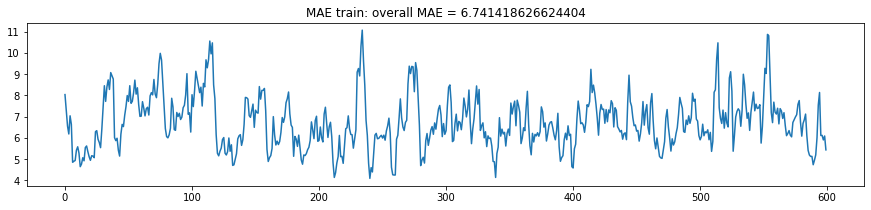

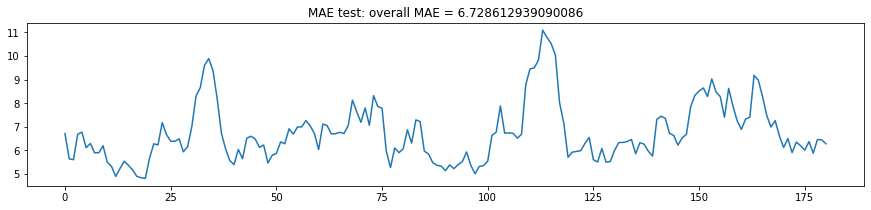

In [47]:

for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()